In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from img_doc import (
    ImageModel, ImageToWords,
    PageModel, PageModelUnit, 
    WordsModel, PhisicalModel,
    WordsToGraph4N,
    Graph4NModel, PhisicalToGraph4N,
    NodeDistExtractot, NodeAngExtractot)

In [55]:
parametr = {
    # "dir": "/home/daniil/program/dataset/train/",
    "dir": "/media/daniil/data/tmp_publaynet/train/",
    "test_file_json": "PMC4631444_00001.jpg.json",
}


In [56]:
image_graph4n_model = PageModel(page_units=[
    PageModelUnit(id="im", sub_model=ImageModel(), extractors=[], converters={}),
    PageModelUnit(id="wd", sub_model=WordsModel(), extractors=[], converters={"im": ImageToWords()}),
    PageModelUnit(id="gr", sub_model=Graph4NModel(), extractors=[NodeDistExtractot(), NodeAngExtractot()], converters={"wd": WordsToGraph4N()})
]
)

graph4n_model = PageModel(page_units=[
    PageModelUnit(id="block_model", sub_model=PhisicalModel(), extractors=[], converters={}),
    PageModelUnit(id="g4n_model", sub_model=Graph4NModel(), extractors=[NodeDistExtractot(), NodeAngExtractot()], converters={"block_model": PhisicalToGraph4N()})
])


In [57]:
file = parametr["dir"]+parametr["test_file_json"]

In [282]:
def graph_from_path(path_file):
    # block_model.read_from_file(path_file)
    graph4n_model.read_from_file(path_file)
    graph4n_model.extract()
    nodes = [w.segment.get_center() for w in graph4n_model.page_units[-1].sub_model.words]
    X = graph4n_model.page_units[-1].sub_model.X
    nodes_feach = [np.array([a], dtype=np.float32).T for a in zip( *X)]
    Y = graph4n_model.page_units[-1].sub_model.Y
    return nodes, graph4n_model.to_dict()["edges"], Y, nodes_feach


def plot_graph(nodes, edges, Y):
    for node, y in zip(nodes, Y):
        plt.scatter(node[0], node[1], color="b" if y == 1 else 'g')
    for i, j, ind in zip(edges[0], edges[1], edges[2]):
        n1 = nodes[i]
        n2 = nodes[j]
        plt.plot([n1[0], n2[0]], [n1[1], n2[1]], "b" if ind == 1 else "r")

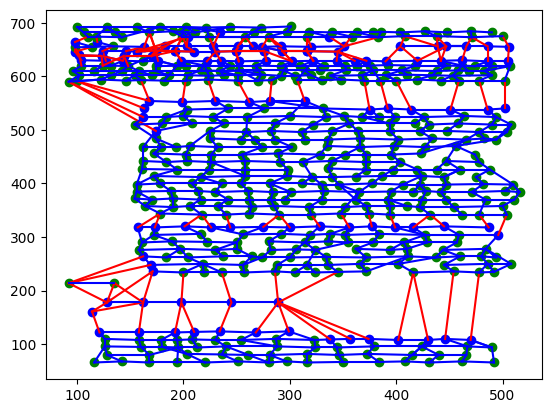

In [274]:
nodes, edges, Y, _ = graph_from_path(file)
plot_graph(nodes, edges, Y)

In [293]:
nodes, edges, Y, _ = graph_from_path(file)

In [295]:
len(nodes)

556

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [301]:
class MyLayer(tf.Module):
    def __init__(self, size_input, size_output, func):
        super().__init__()
        self.size_output = size_output
        self.size_input = size_input
        self.w0 = tf.Variable(tf.random.normal([size_output, size_input],mean=0, stddev=0.001))
        self.w1 = tf.Variable(tf.random.normal([size_output, size_input],mean=0, stddev=0.001))
        self.b = tf.Variable(tf.random.normal([size_output, 1], mean=1, stddev=0.001))
        self.sigma = func
        
    @tf.function()
    def __call__(self, hi):
        x1 = hi[0]
        x2 = tf.subtract(tf.reduce_mean(hi, axis=0), 1/len(hi) * hi[0]) 
        sum_ = tf.matmul(self.w0, tf.transpose([x1]))+tf.matmul(self.w1,tf.transpose([x2]))+self.b
        y = self.sigma(sum_)
        return y
        
class Model:
    def __init__(self):
        self.layer1 = MyLayer(6, 3, tf.nn.relu)
        self.layer2 = MyLayer(3, 1, tf.nn.relu)
        # self.layer1 = MyLayer(2, 2, tf.nn.relu)

    @tf.function()
    def __call__(self, file):
        _, edges, _, nodes = graph_from_path(file)
        e1 = np.array(edges[0])
        e2 = np.array(edges[1])
        index = [[i, *e2[e1 == i]] for i in range(len(nodes))]
        h0 = nodes
        h1 = [self.layer1([tf.transpose(h0[i])[0] for i in index_array]) for index_array in index]
        h2 = [self.layer2([tf.transpose(h1[i])[0] for i in index_array]) for index_array in index]
        return h2
            
@tf.function()
def loss(file, m):
    y = m(file)
    _, _, Y, _ = graph_from_path(file)
    y_true = tf.transpose(np.array([[Y]], dtype=np.float32))
    return tf.reduce_mean(tf.pow(y - y_true , 2))

In [297]:
# m = Model()
# m(file)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b229fcc2aa0>>
Traceback (most recent call last):
  File "/home/daniil/program/python/project/research_phisical_model/env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9979537]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99795413]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9979539]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99795383]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9979537]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99795395]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9980017]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99795413]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9979539]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99795383]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9979537]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=a

In [298]:
import time

In [302]:
learning_rate = 0.001
epochs = 10


In [303]:
hist = []
m = Model()
start = time.time()
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        costF = loss(file, m) 
        hist.append(costF.numpy())
    
    # Спуск
    [l1dw0, l1dw1, l1db, l2dw0, l2dw1, l2db] = tape.gradient(costF, [m.layer1.w0, m.layer1.w1, m.layer1.b,
                                                                    m.layer2.w0, m.layer2.w1, m.layer2.b])   
    stop = time.time()
    time_mean = (stop-start)/(epoch+1)
    print(f"осталось: {time_mean*(epochs-epoch):.2f}  сек", end="\r")
    m.layer1.w0.assign_sub(l1dw0*learning_rate)
    m.layer1.w1.assign_sub(l1dw1*learning_rate)
    m.layer1.b.assign_sub(l1db*learning_rate)
    m.layer2.w0.assign_sub(l2dw0*learning_rate)
    m.layer2.w1.assign_sub(l2dw1*learning_rate)
    m.layer2.b.assign_sub(l2db*learning_rate)

In [270]:
nodes, edges, Y = graph_from_path(file)
nodes

[[116,
  66,
  0.0,
  0.23653819167163276,
  0.10789814535564507,
  0.0,
  0.9970544855015815,
  0.32832056287960487],
 [142,
  68,
  0.0,
  0.19505438975094752,
  0.13200826529874846,
  0.0,
  0.9970544855015815,
  0.6883413933421149],
 [168,
  66,
  0.0,
  0.19505438975094752,
  0.12356354136771994,
  0.0,
  1.0,
  0.49926362137539537],
 [194,
  66,
  0.0,
  0.20957337176664304,
  0.14963327005063873,
  0.0,
  1.0,
  0.5089228826281031],
 [220,
  66,
  0.0,
  0.2323619053440367,
  0.15036599672823855,
  0.0,
  1.0,
  0.6815313254153152],
 [251,
  68,
  0.0,
  0.2323619053440367,
  0.14956766045894967,
  0.0,
  0.9979253089684582,
  0.6878111800453147],
 [280,
  66,
  0.0,
  0.17653420653924934,
  0.1023894526885776,
  0.0,
  0.9931506043228762,
  0.46736337291603847],
 [297,
  68,
  0.0,
  0.1495998878599661,
  0.10513546500420631,
  0.0,
  0.9945054529214061,
  0.6969140143110706],
 [316,
  66,
  0.0,
  0.25442978550086076,
  0.1292536970031992,
  0.0,
  0.999567754464353,
  0.49851

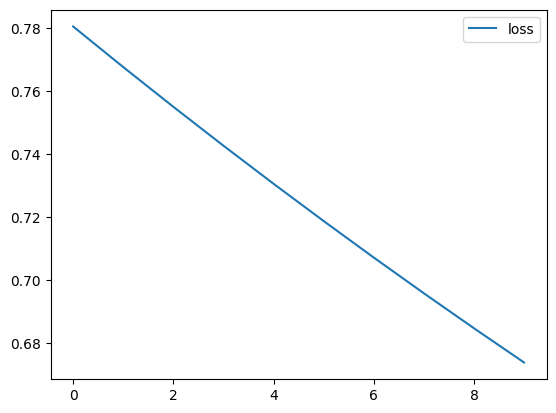

In [304]:
plt.plot(hist)
plt.legend(['loss'])

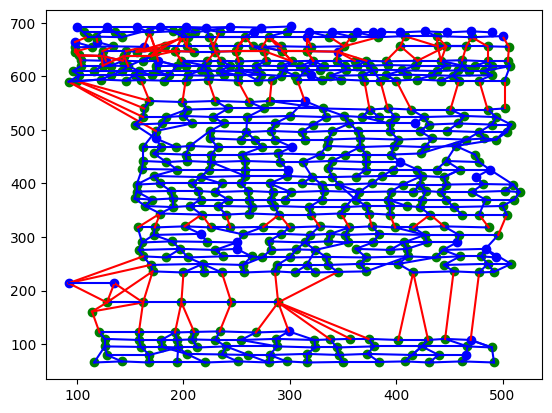

In [312]:
nodes, edges, Y, _ = graph_from_path(file)
y = m(file)
plot_graph(nodes, edges, [1 if yi[0][0] > 0.92 else 0 for yi in y])

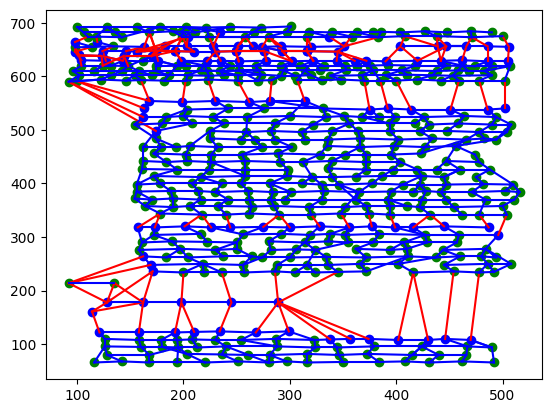

In [259]:
nodes, edges, Y = graph_from_path(file)
plot_graph(nodes, edges, Y)